In [27]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
!nvidia-smi

--2021-09-23 20:03:49--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.1’

helpers.py.1        100%[===================>]     891  --.-KB/s    in 0s      

2021-09-23 20:03:50 (46.1 MB/s) - ‘helpers.py.1’ saved [891/891]

--2021-09-23 20:03:50--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

In [36]:
#import all libraries
import tensorflow.compat.v1 as tf
print(tf.__version__)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
#from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2
import seaborn as sns
from sklearn.manifold import TSNE
#comment importing GaussianBlur in helpers.py
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

2.6.0


In [3]:
#import the dataset 
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 26.77 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [16]:
#loading the images from imported dataset
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images=list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images))
print(len(test_images))

1250
250


In [5]:
#Data augmentation functions
class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)     
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)
        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),tf.cast(p, tf.float32)),lambda: func(x),lambda: x)

In [6]:
#build the data augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [7]:
#image processing
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])
    return image

In [14]:
def prepare_images(image_paths):
    images = []
    labels = []
    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.
        label = image.split("/")[2].split("_")[0]
        images.append(image_pixels)
        labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    print(images.shape, labels.shape)
    return images, labels

In [8]:
# Create TensorFlow dataset
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [9]:
# model architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)
    resnet_simclr = Model(inputs, projection_3)
    return resnet_simclr

In [10]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [11]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)
        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)
        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature
        negatives = tf.concat([zjs, zis], axis=0)
        loss = 0
        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)
            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)
            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature
            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)
        loss = loss / (2 * BATCH_SIZE)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [12]:
def train_simclr(model, dataset, optimizer, criterion,temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []
    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)
            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)
        epoch_wise_loss.append(np.mean(step_wise_loss))
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))
    return epoch_wise_loss, model

  5%|▌         | 1/20 [01:05<20:43, 65.43s/it]

epoch: 1 loss: 4.014


 55%|█████▌    | 11/20 [12:13<09:48, 65.44s/it]

epoch: 11 loss: 3.012


100%|██████████| 20/20 [21:59<00:00, 65.96s/it]


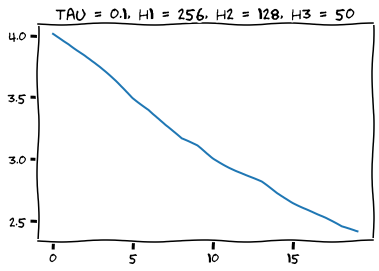

In [29]:
tf.config.run_functions_eagerly(True)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
resnet_simclr_2 = get_resnet_simclr(256, 128, 50)
epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion, temperature=0.1, epochs=20)
with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [30]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

100%|██████████| 1250/1250 [00:06<00:00, 204.17it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 192.60it/s]


(250, 224, 224, 3) (250,)


In [31]:
resnet_simclr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0   

In [22]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()


In [32]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)
print(train_features.shape, test_features.shape)
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True) 

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(1250, 128) (250, 128)


Epoch 1/35
 9/20 [============>.................] - ETA: 0s - loss: 5.9878 - accuracy: 0.1684

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


20/20 [==============================] - 0s 20ms/step - loss: 5.2941 - accuracy: 0.1608 - val_loss: 4.0628 - val_accuracy: 0.1840
Epoch 2/35
20/20 [==============================] - 0s 21ms/step - loss: 3.6252 - accuracy: 0.1936 - val_loss: 2.9513 - val_accuracy: 0.2160
Epoch 3/35
20/20 [==============================] - 0s 19ms/step - loss: 2.5805 - accuracy: 0.2464 - val_loss: 2.1337 - val_accuracy: 0.2800
Epoch 4/35
20/20 [==============================] - 0s 18ms/step - loss: 1.9847 - accuracy: 0.3096 - val_loss: 1.7223 - val_accuracy: 0.3640
Epoch 5/35
20/20 [==============================] - 0s 17ms/step - loss: 1.6943 - accuracy: 0.3656 - val_loss: 1.5520 - val_accuracy: 0.4040
Epoch 6/35
20/20 [==============================] - 0s 19ms/step - loss: 1.5620 - accuracy: 0.4144 - val_loss: 1.4683 - val_accuracy: 0.4360
Epoch 7/35
20/20 [==============================] - 0s 20ms/step - loss: 1.4974 - accuracy: 0.4184 - val_loss: 1.4225 - val_accuracy: 0.4720
Epoch 8/35
20/20 [======

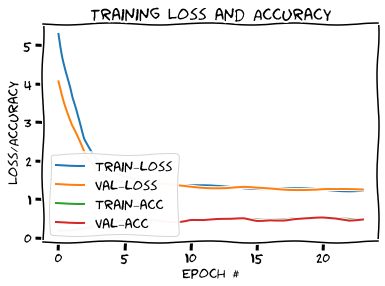

In [33]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,validation_data=(test_features, y_test_enc),batch_size=64,epochs=35,callbacks=[es])
plot_training(history)

In [34]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()
    return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


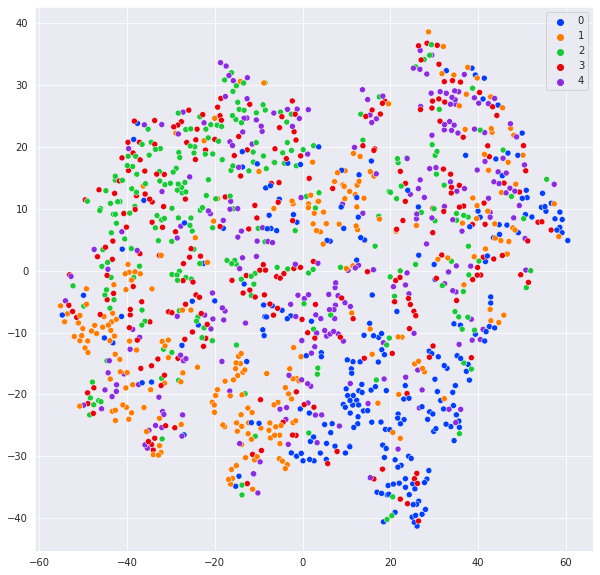

In [39]:
# Representations with linear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)